## Performance Plotter 

This notebook generates graphs comparing the performance of SpinerEOSDependsRhoT (_rt) and SpinerEOSDependsRhoSie (_rs) to EOSPAC (_eos_ref). It uses the .csv results generated from singularity-eos/example/benchmark_spiner_cpu.cpp or the gpu equivalent.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from matplotlib.colors import LogNorm
import math
from IPython.display import display, Markdown #this is for nice tables in the notebook

In [2]:
#rc("font", size = 18) #uncomment to adjust graph text size

### Load Data

In [3]:
#the following loads all necessary data
def load_data(nRho, nT, matid, path):
    # == timer data ==
    times = pd.read_csv(f'{path}/timing_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None)
    
    def reshape(df):
        arr = df.values
        if arr.ndim == 1 or arr.shape != (nRho, nT):
            arr = arr.flatten().reshape((nRho, nT))
        return arr
    
    # == specific internal energy (e_...) per model ==
    e_eos_ref = reshape(pd.read_csv(f'{path}/sie_eos_ref_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None))
    e_rs = reshape(pd.read_csv(f'{path}/sie_rs_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None))
    e_rt = reshape(pd.read_csv(f'{path}/sie_rt_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None))
    
    # == temperature (T_back_...) per model ==
    T_back_eos_ref = reshape(pd.read_csv(f'{path}/T_back_eos_ref_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None))
    T_back_rs = reshape(pd.read_csv(f'{path}/T_back_rs_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None))
    T_back_rt = reshape(pd.read_csv(f'{path}/T_back_rt_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None))
    
    # == pressure (P_...) from density-temperature (_T) per model ==
    P_eos_ref_T = reshape(pd.read_csv(f'{path}/P_eos_ref_T_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None))
    P_rs_T = reshape(pd.read_csv(f'{path}/P_rs_T_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None))
    P_rt_T = reshape(pd.read_csv(f'{path}/P_rt_T_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None))
    
    # == pressure (P_...) from density-energy (_sie) per model ==
    P_eos_ref_sie = reshape(pd.read_csv(f'{path}/P_eos_ref_sie_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None))
    P_rs_sie = reshape(pd.read_csv(f'{path}/P_rs_sie_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None))
    P_rt_sie = reshape(pd.read_csv(f'{path}/P_rt_sie_{matid}_nRho-{nRho}_nT-{nT}.csv', header=None))
    
    # == get axis values ==
    rho_df = pd.read_csv(f'{path}/rho_axis_{matid}_nRho-{nRho}.csv', header=None)
    T_df = pd.read_csv(f'{path}/temp_axis_{matid}_nT-{nT}.csv', header=None)
    rho_ax = rho_df[0].values
    T_ax = T_df[0].values #compare to temperature values here
    rho_ax_log = np.log10(rho_ax) #made these values in log
    T_ax_log = np.log10(T_ax)
    extent = [rho_ax_log[0], rho_ax_log[-1], T_ax_log[0], T_ax_log[-1]] #for plotting purposes later, extent = [xmin, xmax, ymin, ymax]

    #times and the axes arrays do NOT need transposes
    #the transpose is to make density along the x-axes and temperature along the y-axes
    return (times, 
            e_eos_ref.T, e_rs.T, e_rt.T, 
            T_back_eos_ref.T, T_back_rs.T, T_back_rt.T, 
            P_eos_ref_T.T, P_rs_T.T, P_rt_T.T, 
            P_eos_ref_sie.T, P_rs_sie.T, P_rt_sie.T, 
            rho_ax_log, T_ax_log, rho_ax, T_ax, extent)
    

### Users need to change the following 4 parameters here:

In [4]:
path = "Benchmark_Last" #this is the path to the folder storing the .csv data
nRho = 50
nT = 100
matid = 3337

times, e_eos_ref, e_rs, e_rt, T_back_eos_ref, T_back_rs, T_back_rt, P_eos_ref_T, P_rs_T, P_rt_T, P_eos_ref_sie, P_rs_sie, P_rt_sie, rho_ax_log, T_ax_log, rho_ax, T_ax, extent = load_data(nRho,nT, matid, path)

### Computational Efficiency (Time Analysis)

For the timing comparison tests, data on 20 trials per model and lookup type were created by Benchmark.cpp. We discard the first 5 trials and average the remaining 15 to obtain a stable measurement. This accounts for caching effects: during initial iterations, data must be fetched from main memory (RAM) to the CPU. 

In [5]:
model_names = times.iloc[0].tolist() #save first row with column names
times = times.iloc[1:] #take off column names
times = times.apply(pd.to_numeric) # add parameter "errors='coerce' to turn non numeric values to NaN, not neccessary here
last_15 = times.iloc[-15:] #only keep the last 15 for performance sake
times_avg = last_15.mean(axis=0)
times_avg = pd.DataFrame(times_avg).T
times_avg.columns = model_names # add back column names
times_avg = times_avg.round(2).astype(str) + " µs"

In [6]:
var_names = [fr'$\epsilon(\rho, T)$', r'$P(\rho, T)$', r'$P(\rho, \epsilon(\rho, T))$', r'$T(\rho, \epsilon(\rho, T))$']
j = 0
for i in range(0, len(model_names), 3):
    group_cols = model_names[i:i + 3]
    group_df = times_avg[group_cols]
    title = f"{var_names[j]} times for material {matid} ({nRho}x{nT} points):"
    display(Markdown(f"#### {title}"))
    display(group_df)
    j = j + 1
    display(Markdown("<br><br>"))


#### $\epsilon(\rho, T)$ times for material 3337 (50x100 points):

,sie_eos_ref,sie_rt,sie_rs
0,9537.11 µs,175.86 µs,159.4 µs


<br><br>

#### $P(\rho, T)$ times for material 3337 (50x100 points):

,P_eos_ref_T,P_rt_T,P_rs_T
0,9749.81 µs,160.95 µs,159.03 µs


<br><br>

#### $P(\rho, \epsilon(\rho, T))$ times for material 3337 (50x100 points):

,P_eos_ref_sie,P_rt_sie,P_rs_sie
0,54968.01 µs,3100.59 µs,164.42 µs


<br><br>

#### $T(\rho, \epsilon(\rho, T))$ times for material 3337 (50x100 points):

,T_back_eos_ref,T_back_rt,T_back_rs
0,36706.84 µs,3069.67 µs,170.81 µs


<br><br>

### Accuracy Comparison

The baseline for comparisons of accuracy and performance is EOSPAC set to its default settings: rational interpolation, no pre-inversion and no insertion of additional points to the table prior to inversion and interpolation. We choose to use relative percent error. Note that we avoid dividing by zero by adding a minimum denominator value of 1e-10.

In [7]:
error_e_rs = np.abs((e_rs - e_eos_ref) / np.maximum(np.abs(e_eos_ref), 1e-10)) * 100
error_e_rt = np.abs((e_rt - e_eos_ref) / np.maximum(np.abs(e_eos_ref), 1e-10)) * 100

error_P_rs_T = np.abs((P_rs_T - P_eos_ref_T) / np.maximum(np.abs(P_eos_ref_T), 1e-10)) * 100
error_P_rt_T = np.abs((P_rt_T - P_eos_ref_T) / np.maximum(np.abs(P_eos_ref_T), 1e-10)) * 100

error_P_rs_sie = np.abs((P_rs_sie - P_eos_ref_sie) / np.maximum(np.abs(P_eos_ref_sie), 1e-10)) * 100
error_P_rt_sie = np.abs((P_rt_sie - P_eos_ref_sie) / np.maximum(np.abs(P_eos_ref_sie), 1e-10)) * 100

#We know what temperature is, so compare to that 
error_T_back_rs = np.abs((T_back_rs - T_back_eos_ref) / np.maximum(np.abs(T_back_eos_ref), 1e-10)) * 100
error_T_back_rt = np.abs((T_back_rt - T_back_eos_ref) / np.maximum(np.abs(T_back_eos_ref), 1e-10)) * 100

#will iterate through this list to get grid of plots
error_grids = [
    (error_e_rs, error_e_rt),
    (error_P_rs_T, error_P_rt_T),
    (error_P_rs_sie, error_P_rt_sie),
    (error_T_back_rs, error_T_back_rt)
]

In [8]:
# this code block is for creating a consistent colorbar across all plots
all_errors = np.concatenate([
    error_e_rs.ravel(),
    error_e_rt.ravel(),
    error_P_rs_T.ravel(),
    error_P_rt_T.ravel(),
    error_P_rs_sie.ravel(),
    error_P_rt_sie.ravel(),
    error_T_back_rs.ravel(),
    error_T_back_rt.ravel()
])

#find the minimum and maximum value for the colorbar
positive_errors = all_errors[all_errors > 0] #should all be positive anyways
vmin = positive_errors.min() 
vmax = positive_errors.max()

### 2D Visualization of where errors occur on the grid

/usr/lib64/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


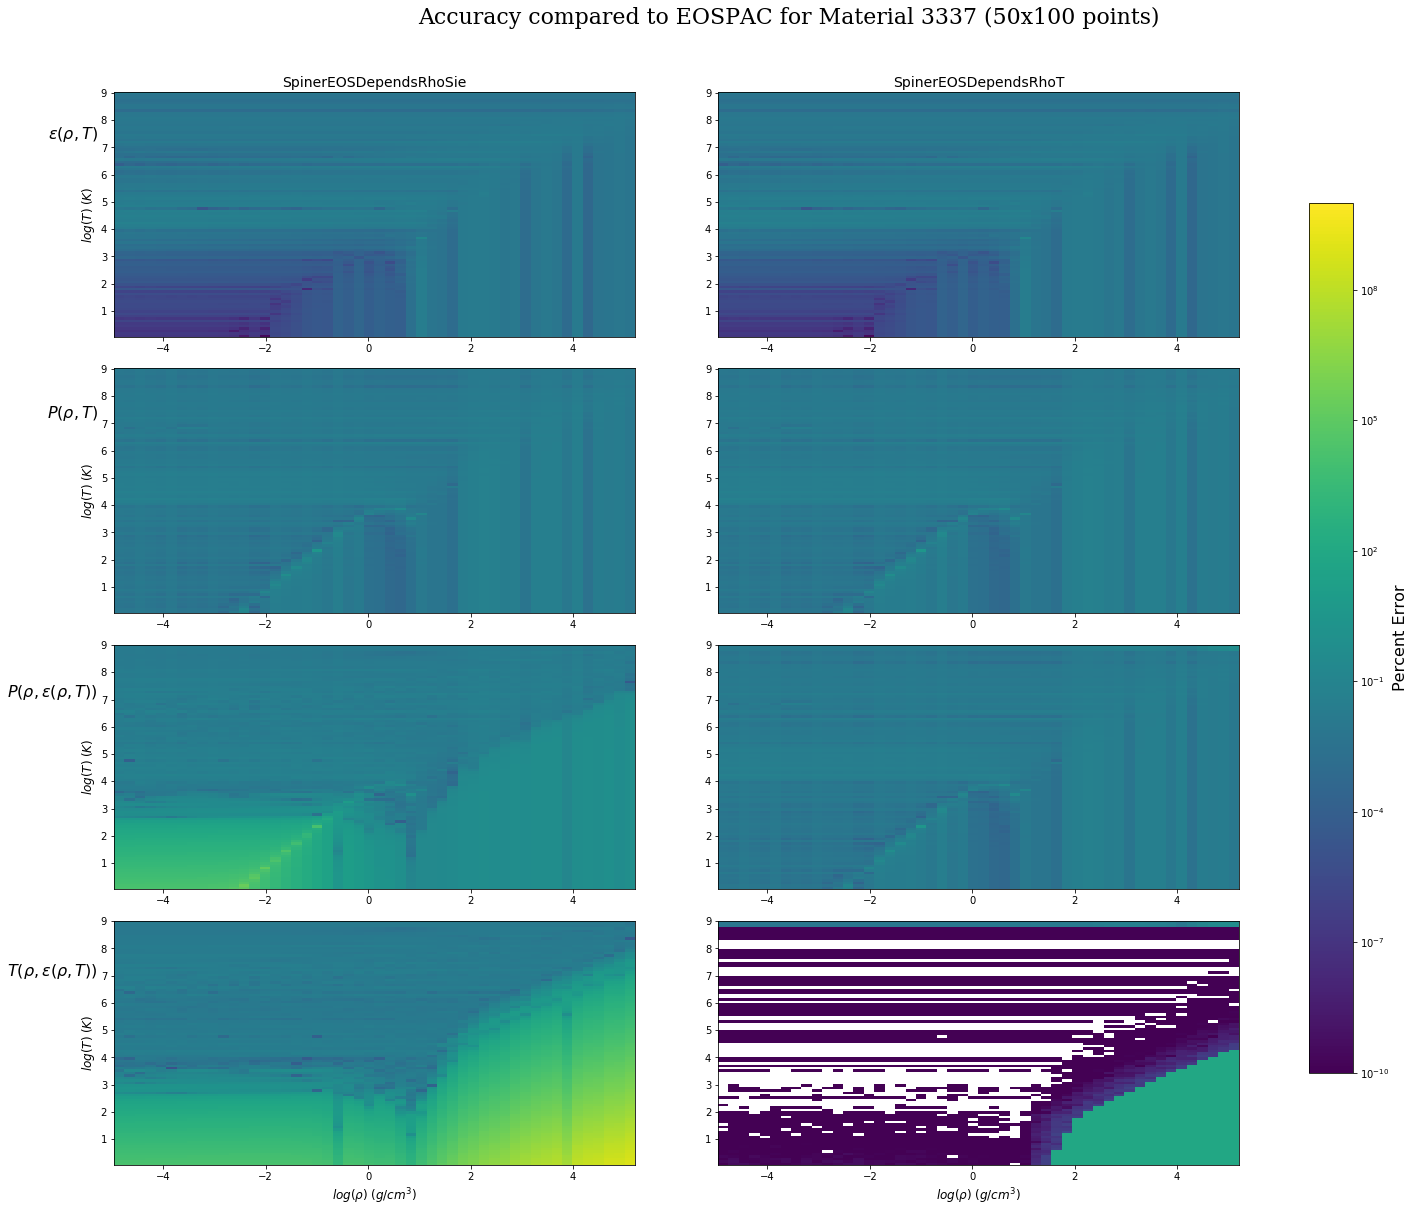

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(20, 16))


for i in range(4):
    im_left = axs[i, 0].imshow(
        error_grids[i][0],
        cmap='viridis',
        origin='lower',
        aspect='auto',
        norm=LogNorm(vmin=10e-11, vmax=10e9),
        extent=extent)
    
    im_right = axs[i, 1].imshow(
        error_grids[i][1],
        cmap='viridis',
        origin='lower',
        aspect='auto',
        norm=LogNorm(vmin=10e-11, vmax=10e9),
        extent=extent)
    
    #set temperature axes labels in loop 
    axs[i, 0].set_ylabel(f'$log(T)\;(K)$', fontsize=12)


#set density axes labels outside of loop
for ax in axs[-1, :]:
    ax.set_xlabel(r'$log(\rho)\;(g/cm^{3})$', fontsize=12)

axs[0, 0].set_title('SpinerEOSDependsRhoSie', fontsize=14)
axs[0, 1].set_title('SpinerEOSDependsRhoT', fontsize=14)

# add function call (e.g. e(rho, T)) labels for rows 
for i in range(4):
    bbox = axs[i, 0].get_position()
    y = 1.23*(bbox.y0 + bbox.height / 2) - 0.042
    fig.text(0.02, y, var_names[i], va='center', ha='right',fontsize=16)

# add shared colorbar on right
cbar = fig.colorbar(im_right, ax=axs, location='right', fraction=0.05, pad=0.5)
cbar.set_label('Percent Error', fontsize=16)


fig.suptitle(f"Accuracy compared to EOSPAC for Material {matid} ({len(rho_ax)}x{len(T_ax)} points)",
    fontsize=22, y=1.05,fontfamily = 'serif')


plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()


### Distribution of Percent Errors

In [10]:
# #the following imports are for plotting aesthetics
# rc("text", usetex=True)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["text.usetex"] = True

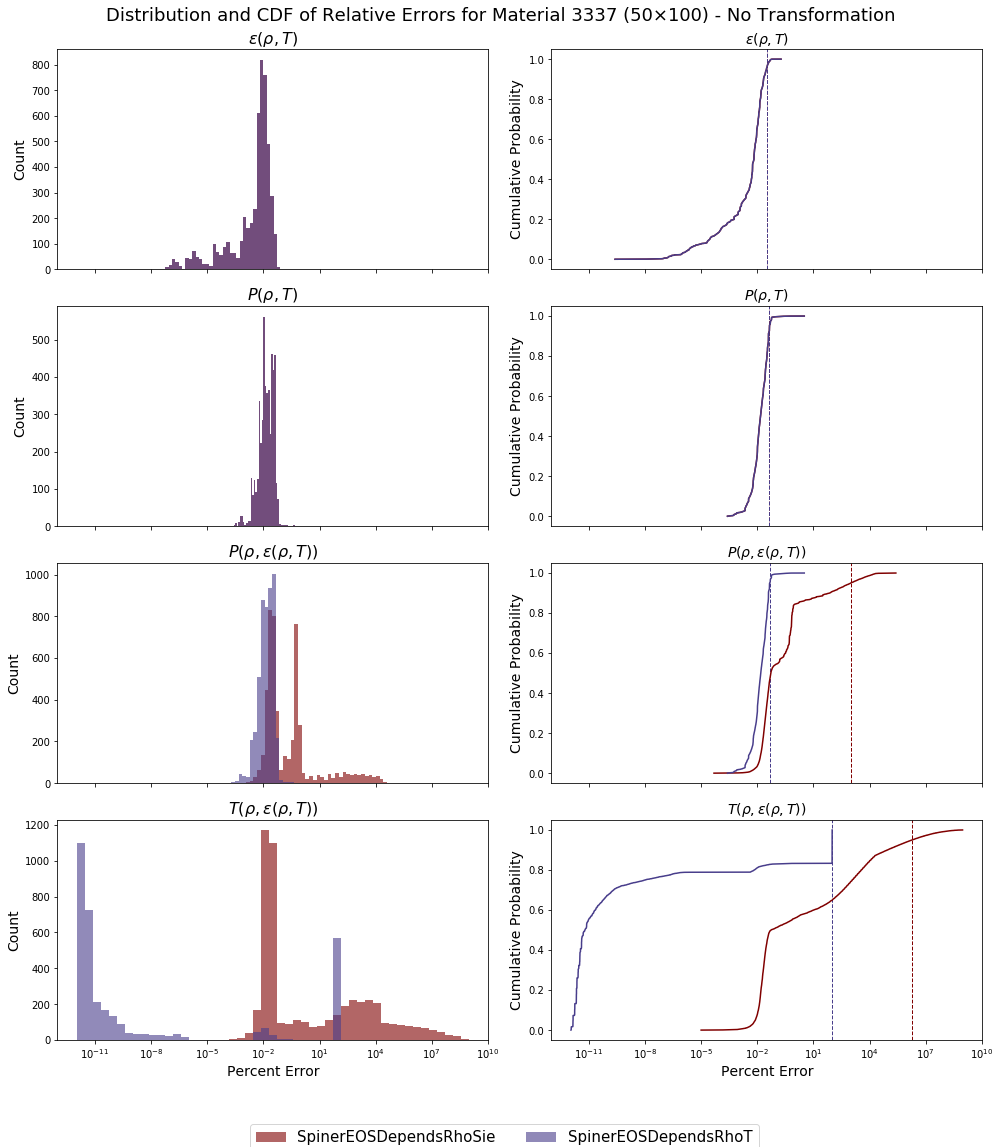

In [11]:
def ecdf(data):
    """Compute empirical CDF for a 1D array"""
    data_sorted = np.sort(data)
    yvals = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
    return data_sorted, yvals

fig, axs = plt.subplots(4, 2, figsize=(14, 16), sharex = True) 

for i in range(4):
    #make grids 1D
    errors_left = error_grids[i][0].values.flatten() if hasattr(error_grids[i][0], 'values') else error_grids[i][0].flatten()
    errors_right = error_grids[i][1].values.flatten() if hasattr(error_grids[i][1], 'values') else error_grids[i][1].flatten()
    
    errors_left = errors_left[errors_left > 0]
    errors_right = errors_right[errors_right > 0]

    # --------------------
    # Histogram (left col)
    # --------------------
    bins = np.logspace(
        np.log10(min(errors_left.min(), errors_right.min())), #HAVE HIM CHECK LOG HERE TOO?
        np.log10(max(errors_left.max(), errors_right.max())), 50)

    axs[i, 0].hist(errors_left, bins=bins, alpha=0.6, label='SpinerEOSDependsRhoSie', color='maroon', density=False)
    axs[i, 0].hist(errors_right, bins=bins, alpha=0.6, label='SpinerEOSDependsRhoT', color='darkslateblue', density=False)
    axs[i, 0].set_xscale('log')
    axs[i, 0].set_ylabel('Count', size = 14)
    axs[i, 0].set_title(f'{var_names[i]}', size = 16)

    # ----------------
    # Cumulative Distribution Function (right col)
    # ----------------
    x_left, y_left = ecdf(errors_left)
    x_right, y_right = ecdf(errors_right)
    
    # compute 95th percentiles and draw dashed lines on graph
    p95_left = np.percentile(errors_left, 95)
    p95_right = np.percentile(errors_right, 95)
    axs[i, 1].axvline(p95_left, color='maroon', linestyle='--', linewidth=1, label='95% RhoSie')
    axs[i, 1].axvline(p95_right, color='darkslateblue', linestyle='--', linewidth=1, label='95% RhoT')

    axs[i, 1].plot(x_left, y_left, label='SpinerEOSDependsRhoSie', color='maroon')
    axs[i, 1].plot(x_right, y_right, label='SpinerEOSDependsRhoT', color='darkslateblue')
    axs[i, 1].set_xscale('log')
    axs[i, 1].set_ylabel('Cumulative Probability', size = 14)
    axs[i, 1].set_title(f'{var_names[i]}', size = 14)
    
#make the legend and add titles/labels
handles, labels = axs[0, 0].get_legend_handles_labels() 
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=15, bbox_to_anchor=(0.5, -0.01)) 
fig.suptitle(f"Distribution and CDF of Relative Errors for Material {matid} ({nRho}×{nT}) - No Transformation", fontsize=18, y=0.98)
for ax in axs[-1, :]:
    ax.set_xlabel('Percent Error', size = 14)

plt.tight_layout(rect=[0, 0.04, 1, 0.97])
plt.show()


### Summary Statistics

In [12]:
def five_point_summary(arr):
    arr = arr[np.isfinite(arr)]
    summary = {
        'min': np.min(arr),
        '25%': np.percentile(arr, 25),
        'median': np.median(arr),
        '75%': np.percentile(arr, 75),
        'max': np.max(arr),
        'mean': np.mean(arr),
        'std': np.std(arr)
    }
    return summary

In [13]:
errors = {
    r'RhoSie: $\epsilon(\rho, T)$': error_e_rs.flatten(),
    r'RhoT: $\epsilon(\rho, T)$': error_e_rt.flatten(),
    r'RhoSie: $P(\rho, T)$': error_P_rs_T.flatten(),
    r'RhoT: $P(\rho, T)$': error_P_rt_T.flatten(),
    r'RhoSie: $P(\rho, \epsilon(\rho, T))$': error_P_rs_sie.flatten(),
    r'RhoT: $P(\rho, \epsilon(\rho, T))$': error_P_rt_sie.flatten(),
    r'RhoSie: $T(\rho, \epsilon(\rho, T))$': error_T_back_rs.flatten(),
    r'RhoT: $T(\rho, \epsilon(\rho, T))$': error_T_back_rt.flatten()
}
summary_tables = {}

for name, data in errors.items():
    summary_tables[name] = five_point_summary(data)
summary_df = pd.DataFrame(summary_tables).T
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={'index': 'Name'})

chunk_size = 2
num_chunks = math.ceil(len(summary_df) / chunk_size)

def short_name(full_name):
    if full_name.startswith('RhoSie'):
        return 'RhoSie'
    elif full_name.startswith('RhoT'):
        return 'RhoT'
    else:
        return full_name

summary_df[''] = summary_df['Name'].apply(short_name)

for i in range(num_chunks):
    start = i * chunk_size
    end = start + chunk_size
    chunk = summary_df.iloc[start:end].copy()  
    base_name = chunk['Name'].iloc[0].split(': ')[1]
    display(Markdown(f"##### Summary Statistics for {base_name} Percent Errors — Material {matid} ({nRho}x{nT} points)"))
    chunk_display = chunk.set_index('').drop(columns=['Name'])
    display(chunk_display)
    display(Markdown("<br><br>"))


##### Summary Statistics for $\epsilon(\rho, T)$ Percent Errors — Material 3337 (50x100 points)

,min,25%,median,75%,max,mean,std
,,,,,,,
RhoSie,2.515248e-10,0.001187,0.006648,0.013051,0.186517,0.009105,0.010209
RhoT,2.515248e-10,0.001187,0.006648,0.013051,0.186517,0.009105,0.010209


<br><br>

##### Summary Statistics for $P(\rho, T)$ Percent Errors — Material 3337 (50x100 points)

,min,25%,median,75%,max,mean,std
,,,,,,,
RhoSie,0.000254,0.008276,0.014778,0.028552,3.23994,0.020495,0.049692
RhoT,0.000254,0.008276,0.014778,0.028552,3.23994,0.020495,0.049692


<br><br>

##### Summary Statistics for $P(\rho, \epsilon(\rho, T))$ Percent Errors — Material 3337 (50x100 points)

,min,25%,median,75%,max,mean,std
,,,,,,,
RhoSie,0.000049,0.025282,0.052047,0.677535,253040.005014,488.750030,5225.435953
RhoT,0.000254,0.008578,0.015346,0.029138,3.239940,0.021454,0.051709


<br><br>

##### Summary Statistics for $T(\rho, \epsilon(\rho, T))$ Percent Errors — Material 3337 (50x100 points)

,min,25%,median,75%,max,mean,std
,,,,,,,
RhoSie,0.00001,0.018383,5.456450e-02,1.181189e+03,9.251514e+08,2.994547e+06,3.023702e+07
RhoT,0.00000,0.000000,2.637699e-12,3.967741e-11,9.999994e+01,1.134414e+01,3.168485e+01


<br><br>